In [582]:
# Reading in the initial data
# Set the data column as the index
# Convert the temperature from fahrenheit to celsius

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
# Use 'test_predictions' for the error metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
#import r2_score
from sklearn.metrics import r2_score

weather = pd.read_csv(r"/Users/thomasgeorgiou/Documents/Coding/Weather forecast/cyprus weather historic.csv", index_col="DATE")

def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) / 1.8


In [583]:
# Convert the temperature columns
temp_columns = ['TAVG', 'TMAX', 'TMIN']

for col in temp_columns:
    weather[col] = weather[col].apply(fahrenheit_to_celsius)

In [584]:
# Print the first five rows of the DataFrame
weather.head()

,STATION,NAME,PRCP,TAVG,TMAX,TMIN
DATE,,,,,,
1976-04-04,CY000176090,"LARNACA, CY",NaN,NaN,18.333333,NaN
1976-04-05,CY000176090,"LARNACA, CY",NaN,NaN,20.555556,8.333333
1976-04-06,CY000176090,"LARNACA, CY",NaN,NaN,20.000000,8.333333
1976-04-07,CY000176090,"LARNACA, CY",NaN,NaN,20.555556,8.888889
1976-04-08,CY000176090,"LARNACA, CY",NaN,NaN,21.666667,7.777778


In [585]:
# Print the summary statistics of the DataFrame
weather.describe()

,PRCP,TAVG,TMAX,TMIN
count,143428.000000,17003.000000,76394.000000,76166.000000
mean,0.060960,19.885608,24.281910,12.725640
std,0.247344,6.222163,7.940429,6.379781
min,0.000000,3.333333,-5.000000,-10.000000
25%,0.000000,14.444444,18.333333,7.777778
50%,0.000000,20.000000,23.888889,12.222222
75%,0.000000,25.555556,30.555556,18.333333
max,10.200000,35.000000,45.555556,31.666667


In [586]:
# Group by date to exclude the location and apply multiple aggregation functions
weather = weather.groupby('DATE').agg({
    'PRCP': 'max',
    'TAVG': 'mean',
    'TMAX': 'max',
    'TMIN': 'min'
})

weather.head()

,PRCP,TAVG,TMAX,TMIN
DATE,,,,
1900-01-01,0.0,NaN,16.111111,1.666667
1900-01-02,0.0,NaN,15.555556,3.888889
1900-01-03,0.0,NaN,16.111111,3.333333
1900-01-04,0.0,NaN,17.777778,4.444444
1900-01-05,0.0,NaN,18.333333,4.444444


In [587]:
# Print the summary statistics of the DataFrame
weather.describe()

,PRCP,TAVG,TMAX,TMIN
count,45041.000000,17003.000000,26416.000000,26235.000000
mean,0.127846,19.885608,26.925517,11.114605
std,0.382925,6.222163,7.599735,6.640178
min,0.000000,3.333333,4.444444,-10.000000
25%,0.000000,14.444444,20.000000,5.555556
50%,0.000000,20.000000,26.666667,11.111111
75%,0.040000,25.555556,33.888889,16.666667
max,10.200000,35.000000,45.555556,28.888889


In [588]:
# Print the index of the DataFrame
weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45178 entries, 1900-01-01 to 2023-09-13
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRCP    45041 non-null  float64
 1   TAVG    17003 non-null  float64
 2   TMAX    26416 non-null  float64
 3   TMIN    26235 non-null  float64
dtypes: float64(4)
memory usage: 1.7+ MB


In [589]:
# Check the percentage of missing values in each column
weather.apply(pd.isnull).sum()/weather.shape[0]

PRCP    0.003032
TAVG    0.623644
TMAX    0.415291
TMIN    0.419297
dtype: float64

<Axes: xlabel='DATE'>

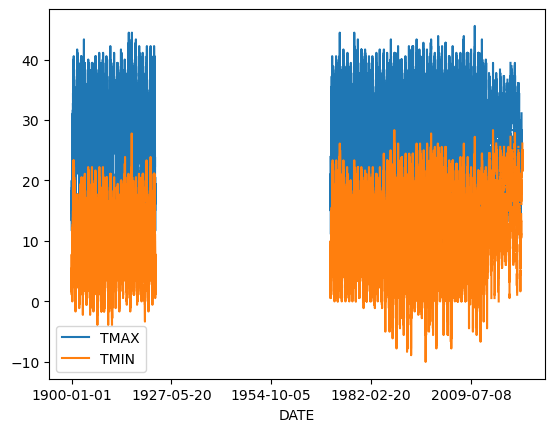

In [590]:
# See whats going on with the missing values
weather[["TMAX", "TMIN"]].plot()

In [591]:
#check for actual number of missing values
weather.apply(pd.isnull).sum()

PRCP      137
TAVG    28175
TMAX    18762
TMIN    18943
dtype: int64

In [592]:
# Check for special fields as specified in the data documentation
weather.apply(lambda x: (x==9999).sum())

PRCP    0
TAVG    0
TMAX    0
TMIN    0
dtype: int64

In [593]:
# Replace the missing values with the median value for that variable
weather.fillna(weather.mean(), inplace=True)


In [594]:
# Check for missing values
weather.apply(pd.isnull).sum()

PRCP    0
TAVG    0
TMAX    0
TMIN    0
dtype: int64

In [595]:
# Convert the index to datetime
weather.index = pd.to_datetime(weather.index)

In [596]:
weather.index

DatetimeIndex(['1900-01-01', '1900-01-02', '1900-01-03', '1900-01-04',
               '1900-01-05', '1900-01-06', '1900-01-07', '1900-01-08',
               '1900-01-09', '1900-01-10',
               ...
               '2023-09-04', '2023-09-05', '2023-09-06', '2023-09-07',
               '2023-09-08', '2023-09-09', '2023-09-10', '2023-09-11',
               '2023-09-12', '2023-09-13'],
              dtype='datetime64[ns]', name='DATE', length=45178, freq=None)

In [597]:
# Select dates after 1975 to avoid the large gap in missing values
weather = weather[(weather.index > '1975-01-01')]

<Axes: xlabel='DATE'>

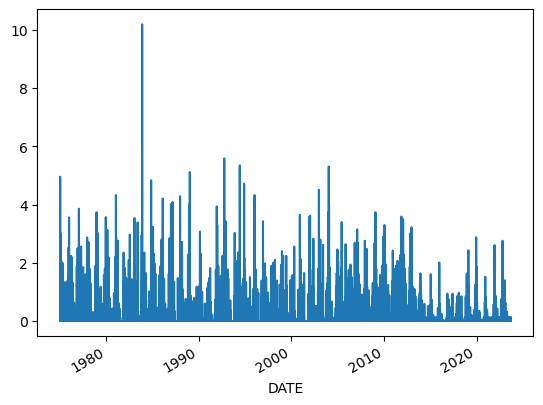

In [598]:
# Plot precipitation
weather["PRCP"].plot()

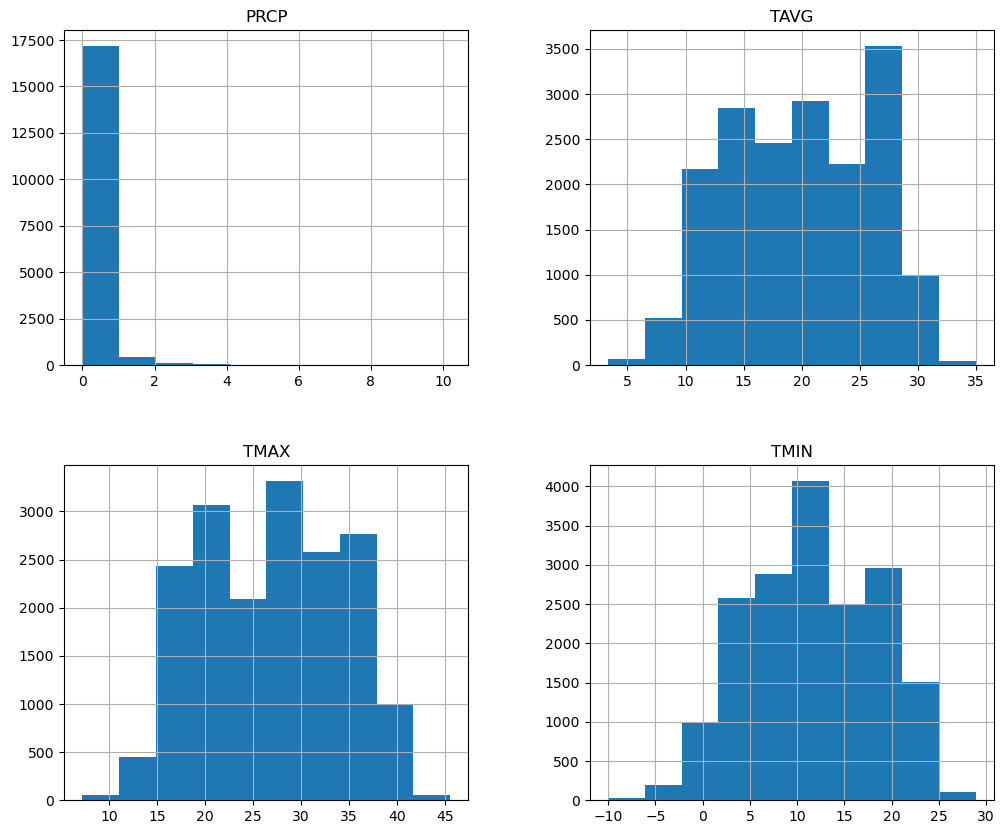

In [599]:
# Plot exploratory plots for all values
weather.hist(figsize=(12, 10))
plt.show()


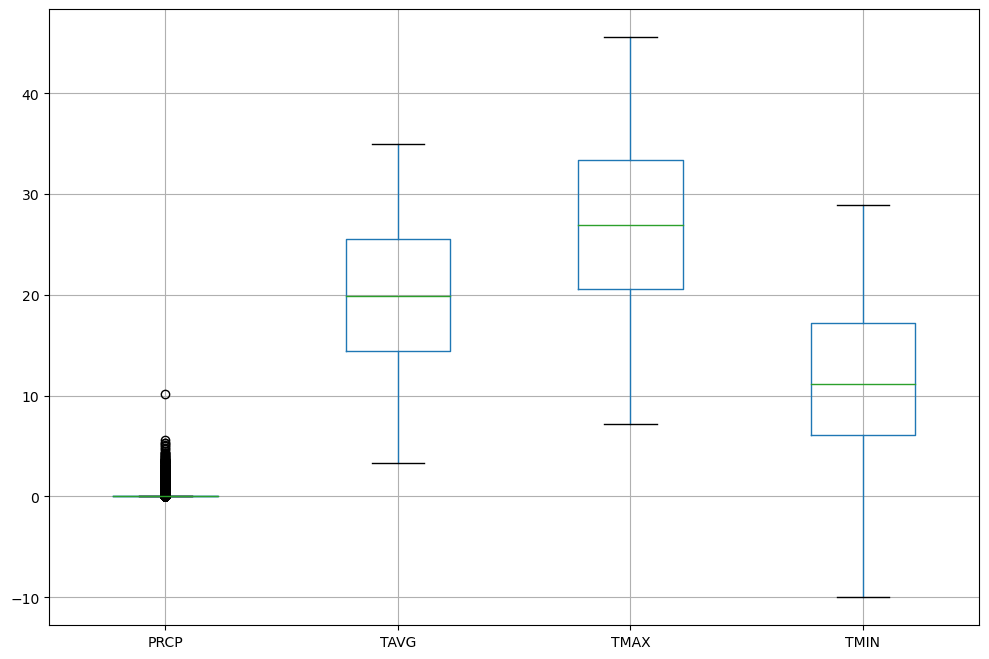

In [600]:
# Plot boxplots for all values
weather.boxplot(figsize=(12, 8))
plt.show()


In [601]:
# Check the summary statistics of the DataFrame now that we excluded and cleaned data
weather.describe()

,PRCP,TAVG,TMAX,TMIN
count,17784.000000,17784.000000,17784.000000,17784.000000
mean,0.129074,19.885608,26.865075,11.424059
std,0.390063,6.083995,7.375092,6.771463
min,0.000000,3.333333,7.222222,-10.000000
25%,0.000000,14.444444,20.555556,6.111111
50%,0.000000,19.885608,26.925517,11.114605
75%,0.030000,25.555556,33.333333,17.222222
max,10.200000,35.000000,45.555556,28.888889


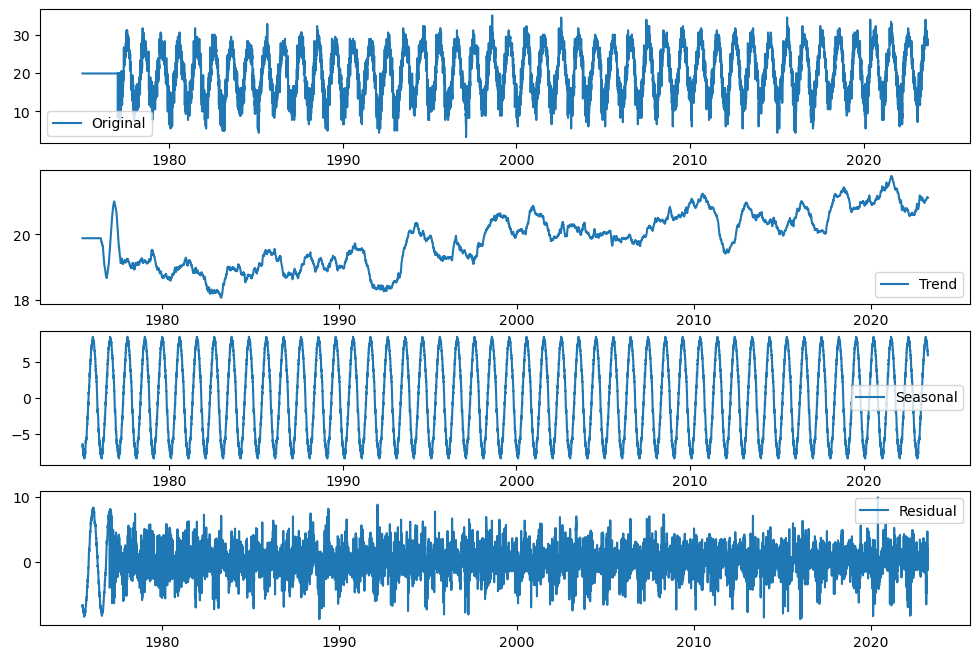

In [602]:
# Plot seasonality of the data

# Decompose the time-series with a frequency of 365 days
decomposition = seasonal_decompose(weather['TAVG'],period=365) # freq depends on the granularity of your data

# Plot each component
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(decomposition.observed, label='Original')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

plt.show()


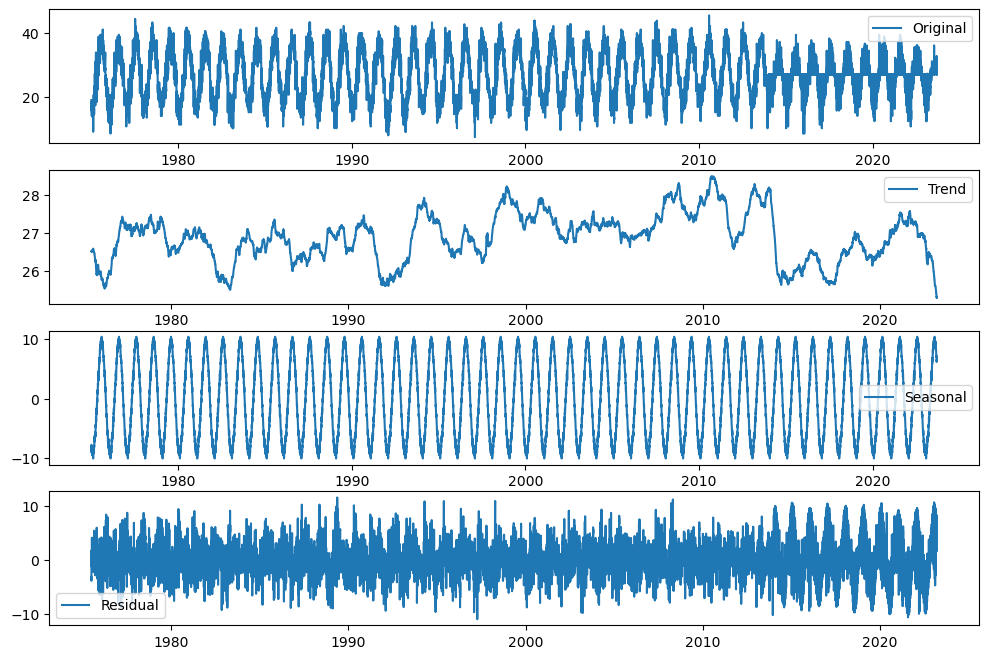

In [603]:
# Plot seasonality of the data

# Decompose the time-series with a frequency of 365 days
decomposition = seasonal_decompose(weather['TMAX'],period=365) # freq depends on the granularity of your data

# Plot each component
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(decomposition.observed, label='Original')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

plt.show()


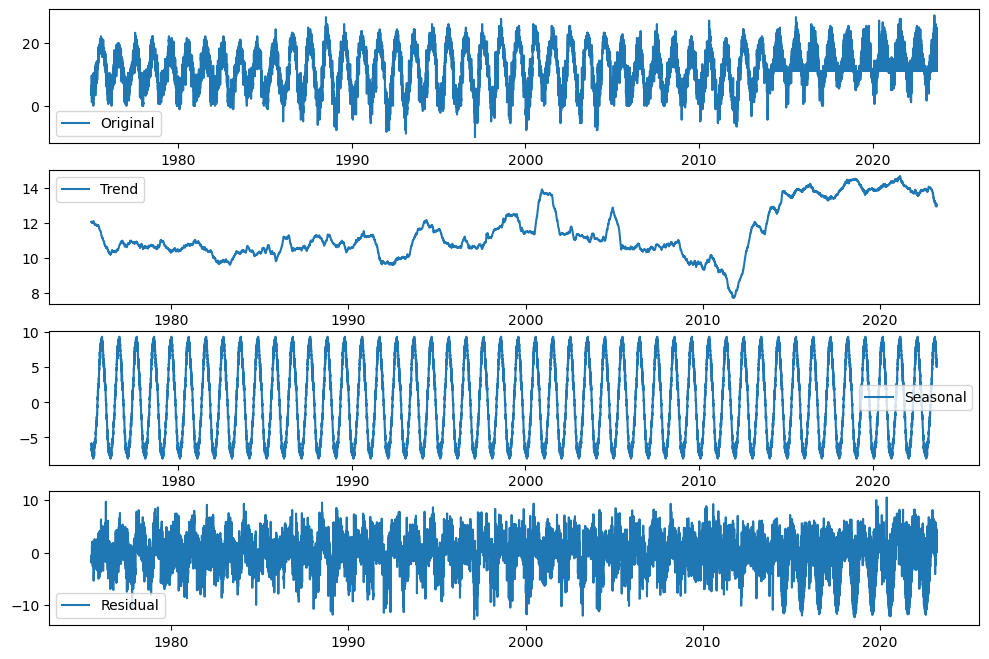

In [604]:
# Plot seasonality of the data

# Decompose the time-series with a frequency of 365 days
decomposition = seasonal_decompose(weather['TMIN'],period=365) # freq depends on the granularity of your data

# Plot each component
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(decomposition.observed, label='Original')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

plt.show()


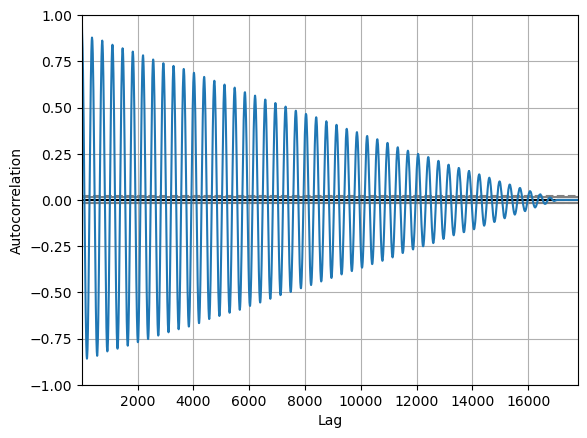

In [605]:
# Plot seasonality of the data
autocorrelation_plot(weather['TAVG'])
plt.show()


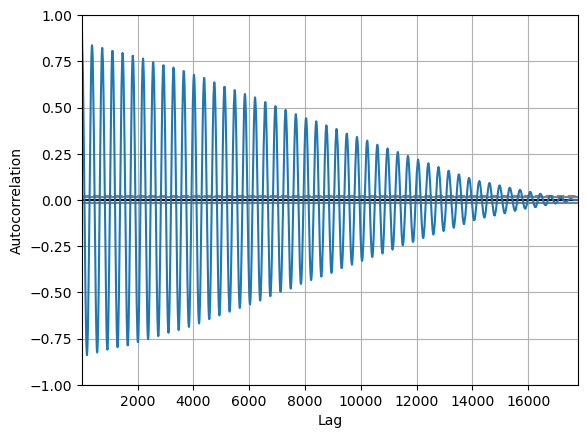

In [606]:
# Plot seasonality of the data
autocorrelation_plot(weather['TMAX'])
plt.show()

In [607]:
# Create lagged variables and rolling mean in the DataFrame to help with forecasting
core_weather = weather.iloc[:-1,:].copy()
core_weather["TMAX_lag1"] = core_weather['TMAX'].shift(1)
core_weather['TMAX_lag2'] = core_weather['TMAX'].shift(2)
core_weather['PRCP_lag1'] = core_weather['PRCP'].shift(1)
core_weather['TAVG_lag1'] = core_weather['TAVG'].shift(1)

window_size = 3  # Size of the rolling window
core_weather['TMAX_rolling_mean'] = core_weather['TMAX'].rolling(window=window_size).mean()

core_weather = core_weather.dropna()
core_weather.head()

,PRCP,TAVG,TMAX,TMIN,TMAX_lag1,TMAX_lag2,PRCP_lag1,TAVG_lag1,TMAX_rolling_mean
DATE,,,,,,,,,
1975-01-04,0.05,19.885608,15.555556,7.222222,16.666667,18.888889,0.17,19.885608,17.037037
1975-01-05,0.00,19.885608,16.666667,3.333333,15.555556,16.666667,0.05,19.885608,16.296296
1975-01-06,0.02,19.885608,16.111111,5.555556,16.666667,15.555556,0.00,19.885608,16.111111
1975-01-07,0.87,19.885608,18.333333,5.000000,16.111111,16.666667,0.02,19.885608,17.037037
1975-01-08,4.96,19.885608,14.444444,4.444444,18.333333,16.111111,0.87,19.885608,16.296296


In [608]:
# Set the predictors which we will use to train the model
predictors = ["TMAX_lag1", "TMAX_rolling_mean", "PRCP_lag1", "TAVG_lag1"]

In [609]:
# Split train and test dataset. Create a separate validation dataset
train = core_weather.loc[:"2022-06-30"]
test = core_weather.loc["2022-07-01":"2022-12-31"]
validation = core_weather.loc["2023-01-01":"2023-06-30"]

In [610]:
# Define custom scorer for MAPE (assuming y_true and y_pred are numpy arrays)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Make it a scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Initialize the StandardScaler to scale the data
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training, test and validation data
train_scaled = scaler.fit_transform(train[predictors])
test_scaled = scaler.transform(test[predictors])
validation_scaled = scaler.transform(validation[predictors])

# TimeSeries Cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Grid Search to find the best parameters for the model
param_grid = {'alpha': np.logspace(-4, 4, 50)}
grid_search = GridSearchCV(Ridge(), param_grid, cv=tscv, scoring={'MSE': 'neg_mean_squared_error', 'MAPE': mape_scorer}, refit='MSE')

# Fit the model on the scaled data
grid_search.fit(train_scaled, train["TMAX"])

# Get the best alpha and best fitted model
best_alpha = grid_search.best_params_['alpha']
best_model = grid_search.best_estimator_

# Make predictions on the scaled test and validation sets
test_predictions = best_model.predict(test_scaled)
validation_predictions = best_model.predict(validation_scaled)

            Mean_Squared_Error
Test                  3.357939
Validation            4.517213


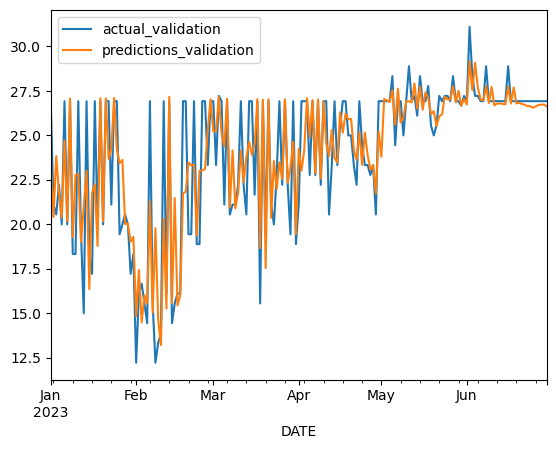

In [611]:
# Create DataFrames for test and validation results
test_combined = pd.DataFrame({
    'actual_test': test["TMAX"],
    'predictions_test': test_predictions
}, index=test.index)

validation_combined = pd.DataFrame({
    'actual_validation': validation["TMAX"],
    'predictions_validation': validation_predictions
}, index=validation.index)

# Calculate validation metrics
test_mse = mean_squared_error(test["TMAX"], test_predictions)
validation_mse = mean_squared_error(validation["TMAX"], validation_predictions)

# Add metrics to a new DataFrame
metrics_df = pd.DataFrame({
    'Mean_Squared_Error': [test_mse, validation_mse]
}, index=['Test', 'Validation'])

validation_combined.plot()
print(metrics_df)

In [612]:
# Check validation metrics for the forecasted values vs the validation dataset

actual_validation = validation_combined['actual_validation']
predictions_validation = validation_combined['predictions_validation']

# Remove any rows where either the actual or predicted values are NaN
filtered_validation = validation_combined.dropna(subset=['actual_validation', 'predictions_validation'])

actual_validation = filtered_validation['actual_validation']
predictions_validation = filtered_validation['predictions_validation']

# Mean Squared Error
mse_validation = mean_squared_error(actual_validation, predictions_validation)
print(f"Validation Mean Squared Error: {mse_validation}")

# Mean Absolute Percentage Error
mape_validation = np.mean(np.abs((actual_validation - predictions_validation) / actual_validation)) * 100
print(f"Validation Mean Absolute Percentage Error (MAPE): {mape_validation}")

# R-squared
r2_validation = r2_score(actual_validation, predictions_validation)
print(f"Validation R-squared: {r2_validation}")

# Mean Absolute Error
mae_validation = mean_absolute_error(actual_validation, predictions_validation)
print(f"Validation Mean Absolute Error (MAE): {mae_validation}")

Validation Mean Squared Error: 4.517213094064763
Validation Mean Absolute Percentage Error (MAPE): 6.583220395103904
Validation R-squared: 0.7333747737484376
Validation Mean Absolute Error (MAE): 1.4286661128391778


In [613]:
# Calculate error metrics for test dataset against test_predictions
mse = mean_squared_error(test["TMAX"], test_predictions)
mape = np.mean(np.abs((test["TMAX"] - test_predictions) / test["TMAX"])) * 100
r2 = r2_score(test["TMAX"], test_predictions)
mae = mean_absolute_error(test["TMAX"], test_predictions)

print("Mean Squared Error:", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("R-squared:", r2)
print("Mean Absolute Error (MAE):", mae)


Mean Squared Error: 3.3579390483133666
Mean Absolute Percentage Error (MAPE): 4.577700566435193
R-squared: 0.8144468887292028
Mean Absolute Error (MAE): 1.288014591668748


In [614]:
# Create a DataFrame with the error metrics
metrics_data = {
    'Mean Squared Error': [mse],
    'Mean Absolute Percentage Error': [mape],
    'R-squared': [r2],
    'Mean Absolute Error': [mae]
}
metrics_df = pd.DataFrame(metrics_data)

metrics_df

,Mean Squared Error,Mean Absolute Percentage Error,R-squared,Mean Absolute Error
0,3.357939,4.577701,0.814447,1.288015


In [615]:
# Combined DataFrame for actual and predictions
combined = pd.concat([test["TMAX"], pd.Series(test_predictions, index=test.index)], axis=1)
combined.columns = ["actual", "predictions"]

combined

,actual,predictions
DATE,,
2022-07-01,32.222222,32.092071
2022-07-02,35.000000,33.496995
2022-07-03,32.222222,32.105679
2022-07-04,33.333333,34.034171
2022-07-05,34.444444,33.208661
...,...,...
2022-12-27,19.444444,20.051519
2022-12-28,20.555556,20.122429
2022-12-29,20.000000,19.855416


<Axes: xlabel='DATE'>

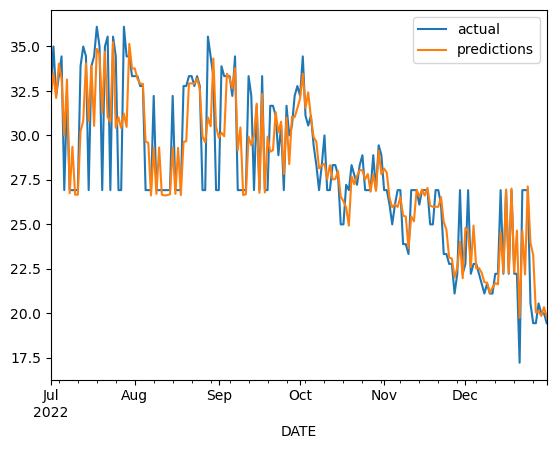

In [616]:
combined.plot()